In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!unzip /content/drive/MyDrive/nflow.zip -d path_to_directory

Archive:  /content/drive/MyDrive/nflow.zip
  inflating: path_to_directory/nflow.csv  


In [1]:
# importing matplotlib module
import matplotlib.pyplot as plt
plt.style.use('default')
# %matplotlib inline: only draw static
# images in the notebook
%matplotlib inline
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.preprocessing import StandardScaler


In [2]:
df = pd.read_csv("path_to_directory/nflow.csv")

In [3]:
df=df.iloc[::80, :]

In [4]:
df.head(5)

,n,timestamp,value,pressure
0,0,902844205,0.998829,-0.979491
80,80,903207304,0.999692,-0.990310
160,160,903365914,0.999506,-0.985417
240,240,903437364,0.999232,-0.995184
320,320,903476472,0.999244,-0.971154


In [5]:
len(df)

446763

In [6]:
df.shape

(446763, 4)

In [7]:
df[df.isnull().any(axis=1)]

,n,timestamp,value,pressure


In [33]:
pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [9]:
def test_stationarity(ts_data, column='', signif=0.05, series=False):
    if series:
        adf_test = adfuller(ts_data, autolag='AIC')
    else:
        adf_test = adfuller(ts_data[column], autolag='AIC')
    p_value = adf_test[1]
    if p_value <= signif:
        test_result = "Stationary"
    else:
        test_result = "Non-Stationary"
    return test_result
"""Multivariate Time Series"""
occ_data = df.set_index('timestamp')
occ_data.head()

,n,value,pressure
timestamp,,,
902844205,0,0.998829,-0.979491
903207304,80,0.999692,-0.990310
903365914,160,0.999506,-0.985417
903437364,240,0.999232,-0.995184
903476472,320,0.999244,-0.971154


In [10]:
occ_data.drop(['n'], axis = 1, inplace = True) 

In [11]:
occ_data.head()

,value,pressure
timestamp,,
902844205,0.998829,-0.979491
903207304,0.999692,-0.990310
903365914,0.999506,-0.985417
903437364,0.999232,-0.995184
903476472,0.999244,-0.971154


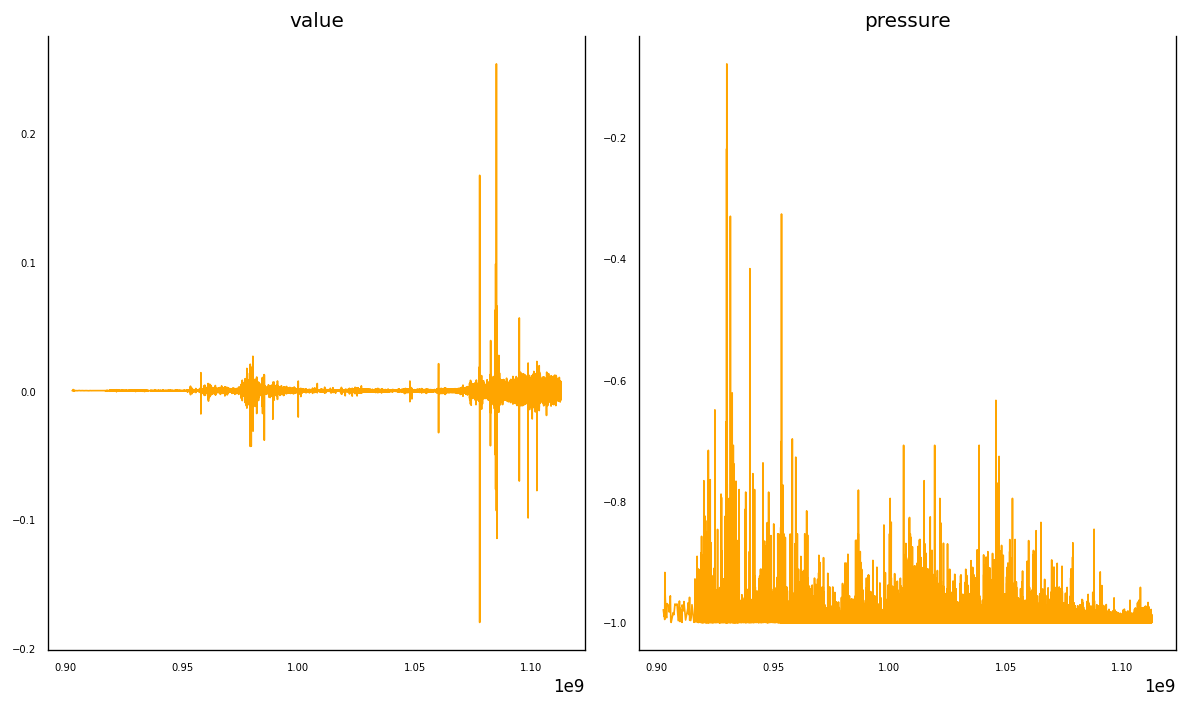

In [45]:
ig, axes = plt.subplots(nrows=1, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = occ_data[occ_data.columns[i]]
    ax.plot(data, color='orange', linewidth=1)
    # Decorations
    ax.set_title(occ_data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [23]:
occ_data.shape

(446763, 2)

In [13]:
adf_test_results = {
    col: test_stationarity(occ_data.iloc[::30, :], col)
    for col in occ_data.columns
}
adf_test_results

{'pressure': 'Stationary', 'value': 'Non-Stationary'}

In [12]:
def differencing(data, column, order):
    differenced_data = data[column].diff(order)
    differenced_data.fillna(differenced_data.mean(), inplace=True)
    return differenced_data

occ_data['value'] = differencing(occ_data,'value', 1)

In [14]:
adf_test_results = {
    col: test_stationarity(occ_data.iloc[::30, :], col)
    for col in occ_data.columns
}
adf_test_results

{'pressure': 'Stationary', 'value': 'Stationary'}

In [74]:
train_df=occ_data[:312734]
test_df=occ_data[312734:]

In [27]:
train_df.shape

(312734, 2)

In [29]:
test_df.shape

(134029, 2)

In [31]:
from statsmodels.tsa.api import VAR
max_lag = 300
var_model = VAR(train_df)
# select the best lag order
lag_results = var_model.select_order(max_lag)
print(lag_results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


  VAR Order Selection (* highlights the minimums)  
        AIC         BIC         FPE         HQIC   
---------------------------------------------------
0        -22.98      -22.98   1.052e-10      -22.98
1        -22.99      -22.99   1.041e-10      -22.99
2        -22.99      -22.99   1.036e-10      -22.99
3        -23.00      -23.00   1.030e-10      -23.00
4        -23.00      -23.00   1.027e-10      -23.00
5        -23.00      -23.00   1.022e-10      -23.00
6        -23.01      -23.01   1.019e-10      -23.01
7        -23.01      -23.01   1.014e-10      -23.01
8        -23.01      -23.01   1.013e-10      -23.01
9        -23.01      -23.01   1.011e-10      -23.01
10       -23.02      -23.02   1.009e-10      -23.02
11       -23.02      -23.02   1.008e-10      -23.02
12       -23.02      -23.02   1.005e-10      -23.02
13       -23.03      -23.02   9.999e-11      -23.03
14       -23.03      -23.03   9.941e-11      -23.03
15       -23.03      -23.03   9.932e-11      -23.03
16       -23

In [33]:
lag_results.aic

295

In [35]:
def find_anomalies(squared_errors):
    threshold = np.mean(squared_errors) + np.std(squared_errors)
    predictions = (squared_errors >= threshold).astype(int)
    return predictions, threshold
var = VAR(train_df)
var_fitresults = var.fit(lag_results.aic)
squared_errors = var_fitresults.resid.sum(axis=1) ** 2
predictions, threshold = find_anomalies(squared_errors)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [40]:
from statistics import mean
threshold = mean(squared_errors) + 1 * np.std(squared_errors)
threshold

0.0022580105289996093

In [41]:
data = train_df.iloc[lag_results.aic:, :]
data['Predictions'] = predictions.values
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,value,pressure,Predictions
timestamp,,,
920386694,-0.000014,-0.999975,0
920391075,0.000081,-0.999724,0
920400465,0.000015,-0.999911,0
920432887,-0.000042,-0.997399,0
920449506,0.000029,-0.985167,0
...,...,...,...
1084473484,-0.000838,-0.999895,0
1084473552,0.004598,-0.981682,0
1084473563,0.000547,-0.998542,0


In [42]:
data['Predictions'].value_counts()

0    311775
1       664
Name: Predictions, dtype: int64

In [46]:
from statsmodels.tsa.statespace.varmax import VARMAX

In [47]:
var_model = VARMAX(train_df, order=(4,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             Statespace Model Results                            
Dep. Variable:     ['value', 'pressure']   No. Observations:               312734
Model:                            VAR(4)   Log Likelihood             2706829.695
                             + intercept   AIC                       -5413617.390
Date:                   Wed, 15 Jun 2022   BIC                       -5413393.675
Time:                           16:40:17   HQIC                      -5413552.798
Sample:                                0                                         
                                - 312734                                         
Covariance Type:                     opg                                         
Ljung-Box (Q):          10440.83, 16067.54   Jarque-Bera (JB):   65378382206.05, 107469851204.17
Prob(Q):                        0.00, 0.00   Prob(JB):                                0.00, 0.00
Heteroskedasticity (H):         3.66, 0.08   Skew:                  

In [161]:
n_forecast = 15000
predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + n_forecast-1))
predictions=predict.predicted_mean



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [162]:
predictions.columns=['value_pred','pressure_pred']
predictions

,value_pred,pressure_pred
312734,-0.000041,-0.997768
312735,-0.000241,-0.998519
312736,0.000141,-0.998567
312737,-0.000027,-0.998477
312738,-0.000020,-0.998408
...,...,...
327729,-0.000005,-0.998429
327730,-0.000005,-0.998429
327731,-0.000005,-0.998429
327732,-0.000005,-0.998429


In [163]:
len(predictions)

15000

In [164]:
test_df2 = test_df.reset_index()
pred2=predictions.reset_index()

In [165]:
test_df2.drop(['timestamp'], axis = 1, inplace = True) 

In [166]:
pred2.drop(['index'], axis = 1, inplace = True) 

In [167]:
test_df2.head(2)

,value,pressure
0,-0.007935,-0.999988
1,-0.002437,-1.000000


In [168]:
pred2.head(2)

,value_pred,pressure_pred
0,-0.000041,-0.997768
1,-0.000241,-0.998519


In [170]:
testAndpred=pd.concat([test_df2[:15000],pred2],axis=1)

In [171]:
testAndpred

,value,pressure,value_pred,pressure_pred
0,-0.007935,-0.999988,-0.000041,-0.997768
1,-0.002437,-1.000000,-0.000241,-0.998519
2,0.007159,-0.999724,0.000141,-0.998567
3,0.002240,-0.999997,-0.000027,-0.998477
4,-0.002782,-0.999930,-0.000020,-0.998408
...,...,...,...,...
14995,-0.002014,-0.999983,-0.000005,-0.998429
14996,-0.004734,-0.999883,-0.000005,-0.998429
14997,-0.005129,-0.999596,-0.000005,-0.998429
14998,-0.000937,-0.999470,-0.000005,-0.998429


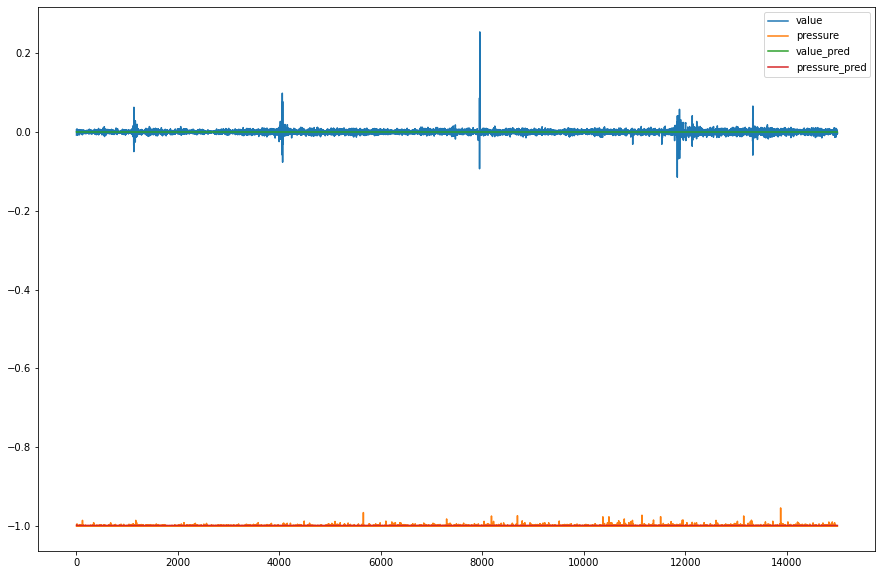

In [172]:
testAndpred.plot(figsize=(15,10))